In [10]:
import pickle
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sksurv.preprocessing import OneHotEncoder as SurvOneHotEncoder
from sksurv.util import Surv

from sksurv.column import encode_categorical
from sksurv.column import standardize
from sksurv.util import Surv

from sklearn.model_selection import train_test_split
from sksurv.ensemble import RandomSurvivalForest
from sksurv.linear_model import CoxnetSurvivalAnalysis

from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
)

def evaluate_model_uno_c(model, test_X, test_y, train_y, times):
    pred = model.predict(test_X)
    uno_concordance = concordance_index_ipcw(train_y, test_y, pred, tau=times[-1])
    return uno_concordance

In [11]:
pickle_file = '../data/DATA_DECEASED_ex.pkl'

with open(pickle_file, 'rb') as f:
    dataset = pickle.load(f)


In [12]:
numeric_features = [
    "AGE",
    "KDPI",
    "DIALYSIS_TIME",
    "AGE_DON",
    "BMI_CALC",
    "CREAT_TRR",
    "NPKID",
    "COLD_ISCH_KI",
]
categorical_features = [
    "ON_DIALYSIS",
    "DIAB",
    "HCV_SEROSTATUS",
    "PRE_TX_TXFUS",
    "GENDER",
    "ETHCAT",
    "DIABETES_DON",
]


In [13]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformations for all features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Set up the final pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# Apply preprocessing to X
# X = pipeline.fit_transform(dataset[categorical_features + numeric_features ])

categorical_x = encode_categorical(dataset[categorical_features])
numerical_x = standardize(dataset[numeric_features])
X = pd.concat([numerical_x, categorical_x], axis=1)

survival_time = dataset["PTIME"].astype(np.float64)
event = dataset["PSTATUS"].astype(float).astype(bool)

y = Surv.from_arrays(event, survival_time, "Status", "Days")

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y["Status"], random_state=42)

In [15]:
from sksurv.ensemble import GradientBoostingSurvivalAnalysis

# est = GradientBoostingSurvivalAnalysis(n_estimators=3, learning_rate=1)
# est.fit(X_train, y_train)
# est.score(X_test, y_test)

In [16]:
pickle_file = '../TrainedModels/FINAL_GBSA_0.698_lr0.2_deceased_early_stopping.pkl'

with open(pickle_file, 'rb') as f:
    best_model = pickle.load(f)

In [17]:
from sklearn.inspection import permutation_importance

# uncoment if you want to calculate permutation importance (data must not be processed by pipeline)
result = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=0, n_jobs=-1)
# result = permutation_importance(est, X_test, y_test, n_repeats=10, random_state=0, n_jobs=-1)

In [18]:
pd.set_option('display.max_rows', None)

# columns = numeric_features + categorical_features

importances_df = pd.DataFrame(result.importances_mean, index=X_train.columns)
importances_df.columns = ['Importance']
importances_df.sort_values(by='Importance', ascending=False, inplace=True)

# Print out feature importances
print(importances_df)

                   Importance
AGE                  0.099173
DIAB=5.0             0.016698
DIAB=3.0             0.014443
KDPI                 0.007916
DIALYSIS_TIME        0.006054
CREAT_TRR            0.006047
ON_DIALYSIS=Y        0.005259
DIAB=2.0             0.004851
HCV_SEROSTATUS=P     0.003661
ETHCAT=4             0.003340
ETHCAT=5             0.002964
GENDER=M             0.002547
BMI_CALC             0.002120
PRE_TX_TXFUS=Y       0.001644
AGE_DON              0.001427
NPKID                0.000793
ETHCAT=2             0.000738
COLD_ISCH_KI         0.000559
DIABETES_DON=Y       0.000098
DIAB=4.0             0.000054
HCV_SEROSTATUS=ND    0.000052
DIAB=998.0           0.000028
ETHCAT=7             0.000026
ETHCAT=6            -0.000030


<Axes: title={'center': 'GBSA Feature Permutation Importance Deceased'}>

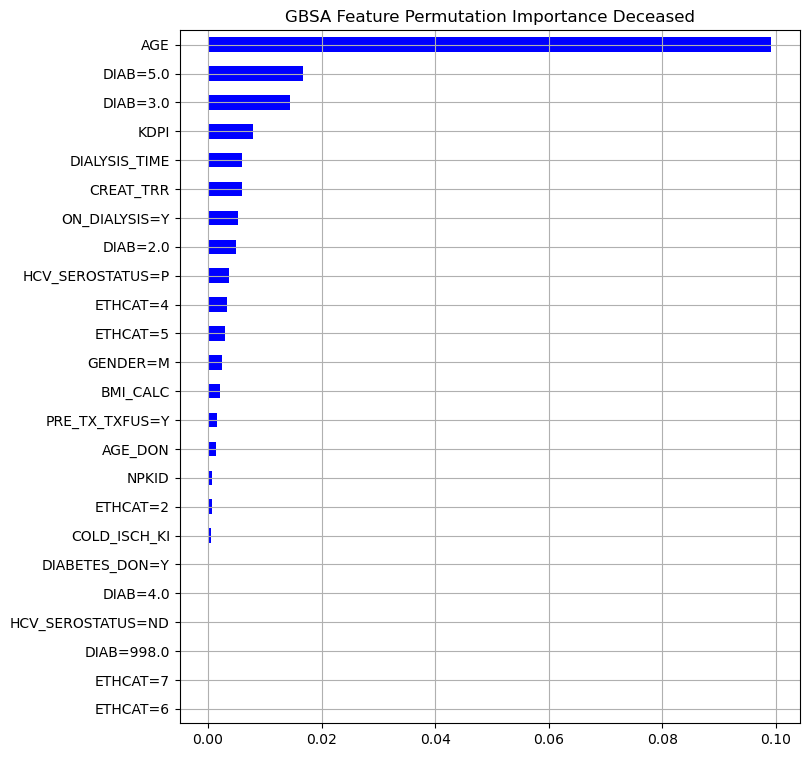

In [20]:
plt_importances =importances_df.sort_values(by='Importance', ascending=True)
plt_importances.plot.barh(color='blue', legend=False, title='GBSA Feature Permutation Importance Deceased', grid=True, figsize=(8, 9))